In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import glob 
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.ndimage.filters import uniform_filter1d
import statistics

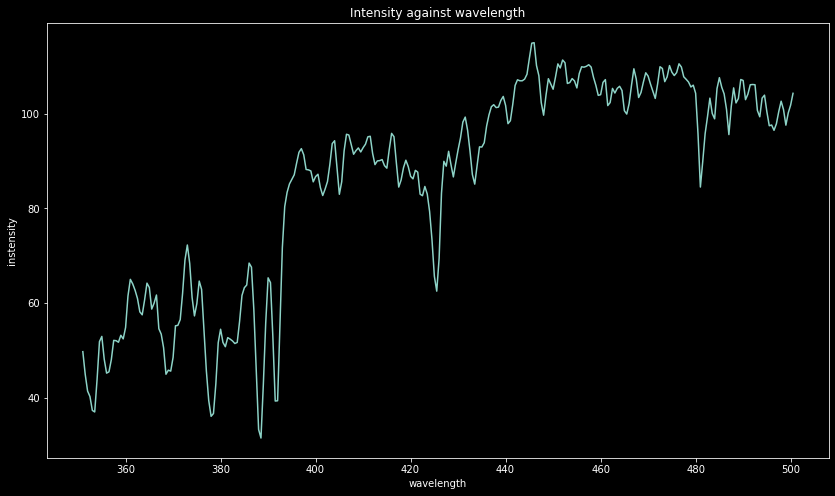

In [2]:
filename = 'G8V_template.txt'
data = np.loadtxt(filename, usecols=(0,1))
wavelength, intensity = data[:,0], data[:,1] #importing data

%matplotlib inline
plt.style.use('dark_background') #set plot style here
plt.rcParams['figure.figsize'] = [14, 8]


plt.plot(wavelength[0:300], intensity[0:300])
plt.xlabel('wavelength')
plt.ylabel('instensity')
plt.title('Intensity against wavelength')
plt.savefig('./images/'+filename+'.jpg')

In [3]:
test_velocity = 2.5e6 #defining some constants
c = 299792458
HD28185_period = 383
HD73256_period = 2.54858
sun_mass=1.989e30
jupiter_mass = 1.898e27
G= 6.673e-11

In [4]:
def shift_spectrum(wavelength, intensity, v):#defining the shiftspectrum that we're going to use to plot the doppler shifted spectrum
    shiftedWavelength, shiftedIntensity = wavelength * (1.0 + v/c), intensity / (1.0 + v/c)
    interpolatedShift = interp1d(shiftedWavelength, shiftedIntensity,
            bounds_error = False, fill_value = (intensity[0], intensity[-1]))(wavelength)
    return interpolatedShift

def costFunction(v, wavelengths, intensities, template): #defining the costfunction that we're going to use later with the minimize function
    return np.sum((template - shift_spectrum(wavelengths, intensities, v))**2)

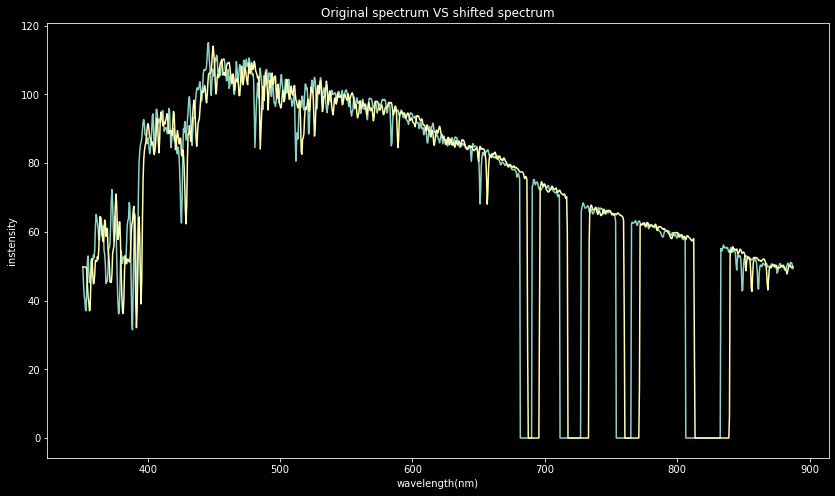

In [5]:
plt.plot(wavelength, intensity) #plotting the original data for comparision
plt.plot(wavelength, shift_spectrum(wavelength, intensity, test_velocity)) #plotting the shifted data
plt.title('Original spectrum VS shifted spectrum')
plt.xlabel('wavelength(nm)')
plt.ylabel('instensity')
plt.savefig('./images/'+'original_vs_shifted_spectrum'+'.jpg')

In [6]:
def minimize_function(filenames, period):
    timestamps =[]
    minimized_datapoints = []
    for file in filenames:
        data = np.genfromtxt(file, usecols = (0, 1, 2), invalid_raise = False)
        timestamps.append(float(file[13:-4]))
        wavelengths, templateSpectrum, intensity = data[:,0], data[:,1], data[:,2]
        minimized = minimize(costFunction, 30000, args=(wavelengths,
                    templateSpectrum, intensity), method = 'Powell')
        minimized_datapoints.append(float(minimized.x))
    phase = ((np.array(timestamps)-timestamps[0])/period)%1
    return minimized_datapoints, phase

In [7]:
HD28185 = glob.glob('./HD-28185/*.txt')
HD73256 = glob.glob('./HD-73256/*.txt')

HD28185_minimized, HD28185_phase = minimize_function(HD28185, HD28185_period)
HD73256_minimized, HD73256_phase = minimize_function(HD73256, HD73256_period)

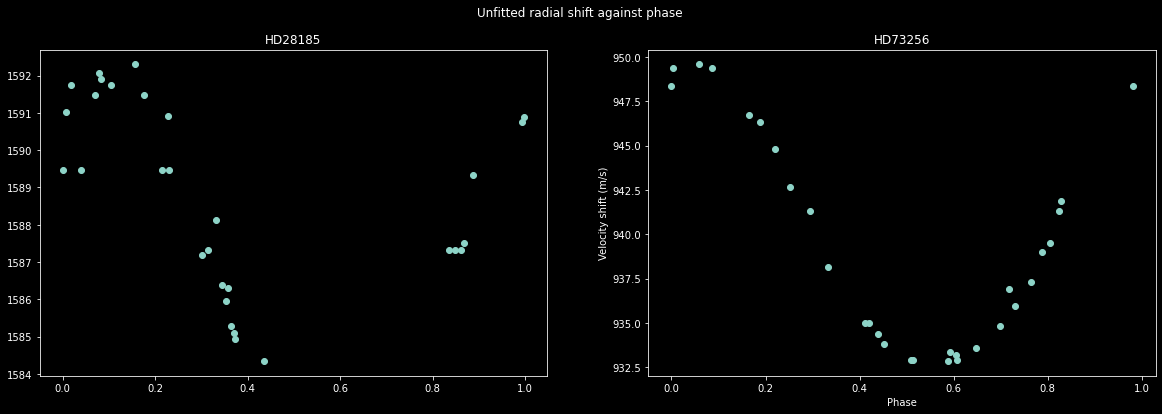

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
axs[0].scatter(HD28185_phase, HD28185_minimized)
axs[1].scatter(HD73256_phase, HD73256_minimized)
axs[0].title.set_text('HD28185')
axs[1].title.set_text('HD73256')
# plt.ylim([-0.05,0.05])
fig.suptitle('Unfitted radial shift against phase')
plt.xlabel('Phase')
plt.ylabel('Velocity shift (m/s)')
plt.savefig('./images/'+'uniffted_radial_shift_against_phase'+'.jpg')

In [9]:
def sin_cost_function(phase, mean_velocity, velocity_shift, phase_shift):
    return np.array(mean_velocity+velocity_shift*np.sin(2*np.pi*phase+phase_shift))

mean velocity, velocity shift, phase shift
[0.1994864  0.30677399 0.04060146] errors on the fitted variables


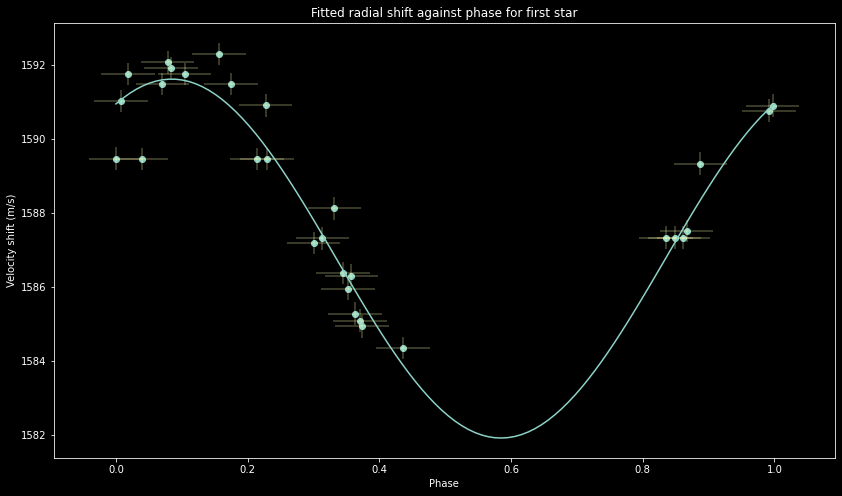

mean velocity, velocity shift, phase shift
[0.10987233 0.1542302  0.01843528] errors on the fitted variables


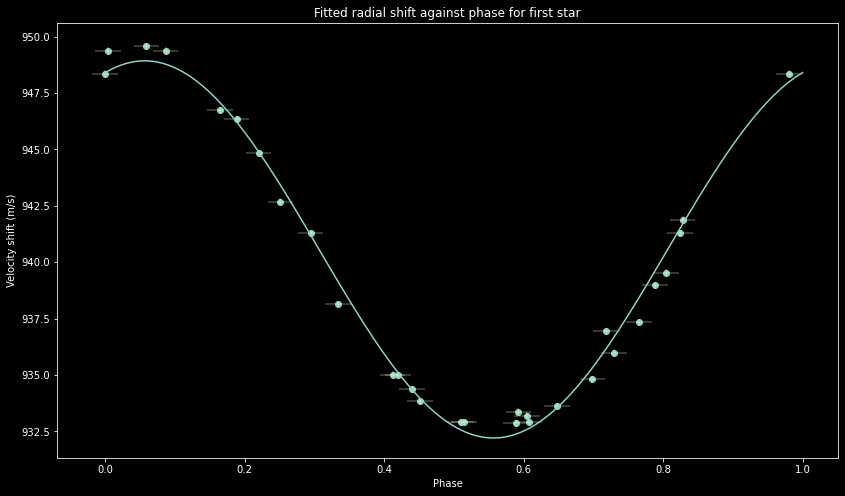

In [10]:
"""
need some more reading into estimating sigma
"""


def fit_and_plot(phase, velocity_data):
    popt, pcov = curve_fit(sin_cost_function, phase, velocity_data,
                p0=[np.mean(velocity_data),
                (max(velocity_data)-min(velocity_data))/2, 0],
                sigma = np.full((len(velocity_data)),
                statistics.pstdev(velocity_data)), absolute_sigma = False)
    
    newfit = sin_cost_function(phase, popt[0], popt[1], popt[2])
    residuals = popt[0]+newfit-velocity_data #calculates standard deviation from the data residuals
    newstddev = statistics.pstdev(residuals) #for later use on the errorbars
    #thes three lines might be useless after all. it seems that perr does the job very well
    
    perr = np.sqrt(np.diag(pcov))
    print('mean velocity, velocity shift, phase shift')
    print(perr, 'errors on the fitted variables')
    
    plt.scatter(phase, velocity_data) #plotting the original data for comparision
    plt.plot(np.linspace(0,1,100), sin_cost_function(np.linspace(0,1,100),
            popt[0], popt[1], popt[2])) #plotting the fitted sine line
    plt.errorbar(phase, velocity_data, yerr=perr[1], xerr = perr[2],fmt='none', colour='r', alpha = 0.3)
    plt.title('Fitted radial shift against phase for first star')
    plt.xlabel('Phase')
    plt.ylabel('Velocity shift (m/s)')
    plt.savefig('./images/'+'fitted_radial_shift_{}'+'.jpg')
    plt.show()
    return popt, pcov

poptHD28185, pcovHD28185 = fit_and_plot(HD28185_phase, HD28185_minimized)
poptHD73256, pcovHD73256 = fit_and_plot(HD73256_phase, HD73256_minimized)

## Why do I get such massive errors on phase?
It might have somethin to do with the absolute_sigma=True argument; look into it

In [11]:
def exoplanet_parameters(star_period, popt):
    
    period_in_seconds=star_period*24*60*60
    semi_major_axis = (period_in_seconds**2*((4*np.pi**2/(G*sun_mass))**-1))**(1/3)
    v_planet = (G*sun_mass/semi_major_axis)**0.5
    planets_mass = sun_mass*popt[1]/v_planet
    
    print(f'The orbital velocity of the planet {v_planet/1e3: .3} km/s')
    print(f'mass of planet orbiting the star={planets_mass: .3} kg, or {planets_mass/jupiter_mass : .3} Jupiter masses')
    print(f'semi-major axis of planet orbiting HD-28185= {semi_major_axis: .3} m, or {(semi_major_axis/1.49611e11): .4} AU \n')


In [13]:
exoplanet_parameters(HD28185_period, poptHD28185)
exoplanet_parameters(HD73256_period, poptHD73256)
print(poptHD28185[0], poptHD28185[1], poptHD28185[2])

The orbital velocity of the planet  29.3 km/s
mass of planet orbiting the star= 3.29e+26 kg, or  0.174 Jupiter masses
semi-major axis of planet orbiting HD-28185=  1.54e+11 m, or  1.032 AU 

The orbital velocity of the planet  1.56e+02 km/s
mass of planet orbiting the star= 1.07e+26 kg, or  0.0563 Jupiter masses
semi-major axis of planet orbiting HD-28185=  5.46e+09 m, or  0.03651 AU 

1586.7649336540046 4.8563424933950445 1.0386579393583173


SO it seems that HD28185 is very Jovian-like planet with its orbital period of around a year, and its mass is comparable to that of Jupiter's.

HD28185 is more of a Mercury-like planet, with very short orbital period and an extremely small semi-major axis.

### Part 2: Examining the light curve.

<ErrorbarContainer object of 3 artists>

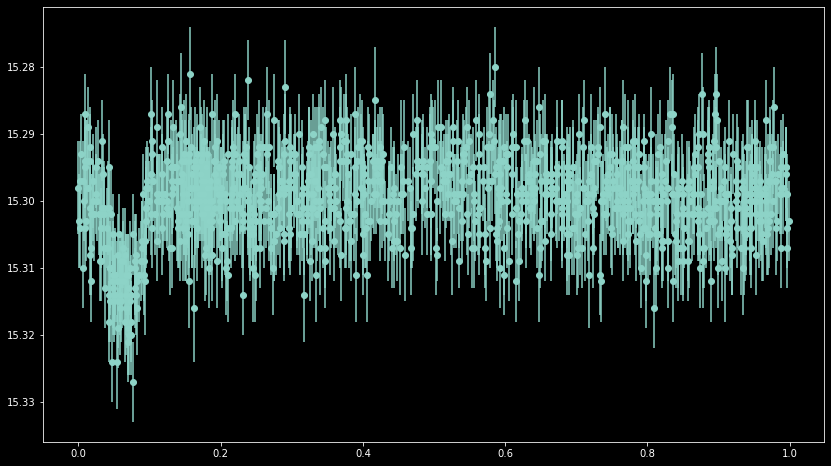

In [14]:
data = np.loadtxt('OGLE_III_TR56.txt', usecols = (0, 1, 2))
julian_days, i_band_mag, magnitude_error = (data[:,0]),data[:,1], data[:,2]
#importing the data

#converting julain dates into phases
phases = ((np.array(julian_days)-julian_days[0])/1.2119)%1

plt.scatter(phases, i_band_mag)
plt.gca().invert_yaxis() #since lower magnitude means brighter object
plt.errorbar(phases, i_band_mag, yerr=magnitude_error,fmt='none')

This is extremely clustered, we need an average line to get a better idea of what's happening.

In [15]:
zipped = list(zip(phases, i_band_mag)) #zipping the lists together to sort then

# def sort_tuple(tup): #for some reason this is the only way i found to sort a list of tuples
#     tup.sort(key = lambda x: x[0])
#     return tup

# unzipped = np.array(sort_tuple(zipped))
# phases_new, i_band_mag_new = unzipped[:, 0], unzipped[:, 1]

unzipped = list(zip(*sorted(zipped, key=lambda x: x[0])))

# phases_new, i_band_mag_new = *sorted(zipped, key=lambda x: x[0])
# print(sorted_idxs)#
# print(unzipped)

# unzipped = list(zip(*sort_tuple(zipped)))
phases_new, i_band_mag_new = unzipped[0], unzipped[1]
# print(list(phases_new))

In [16]:
list_ = ['lukas', 'gabrielius', '101', 'domas']
sorted(list_, key = len)

def f420():
    return 420

def plus10(f):
    return f() + 10

plus10_lambda = lambda x: x() + 10

# plus10(f420)
plus10_lambda(f420)


430

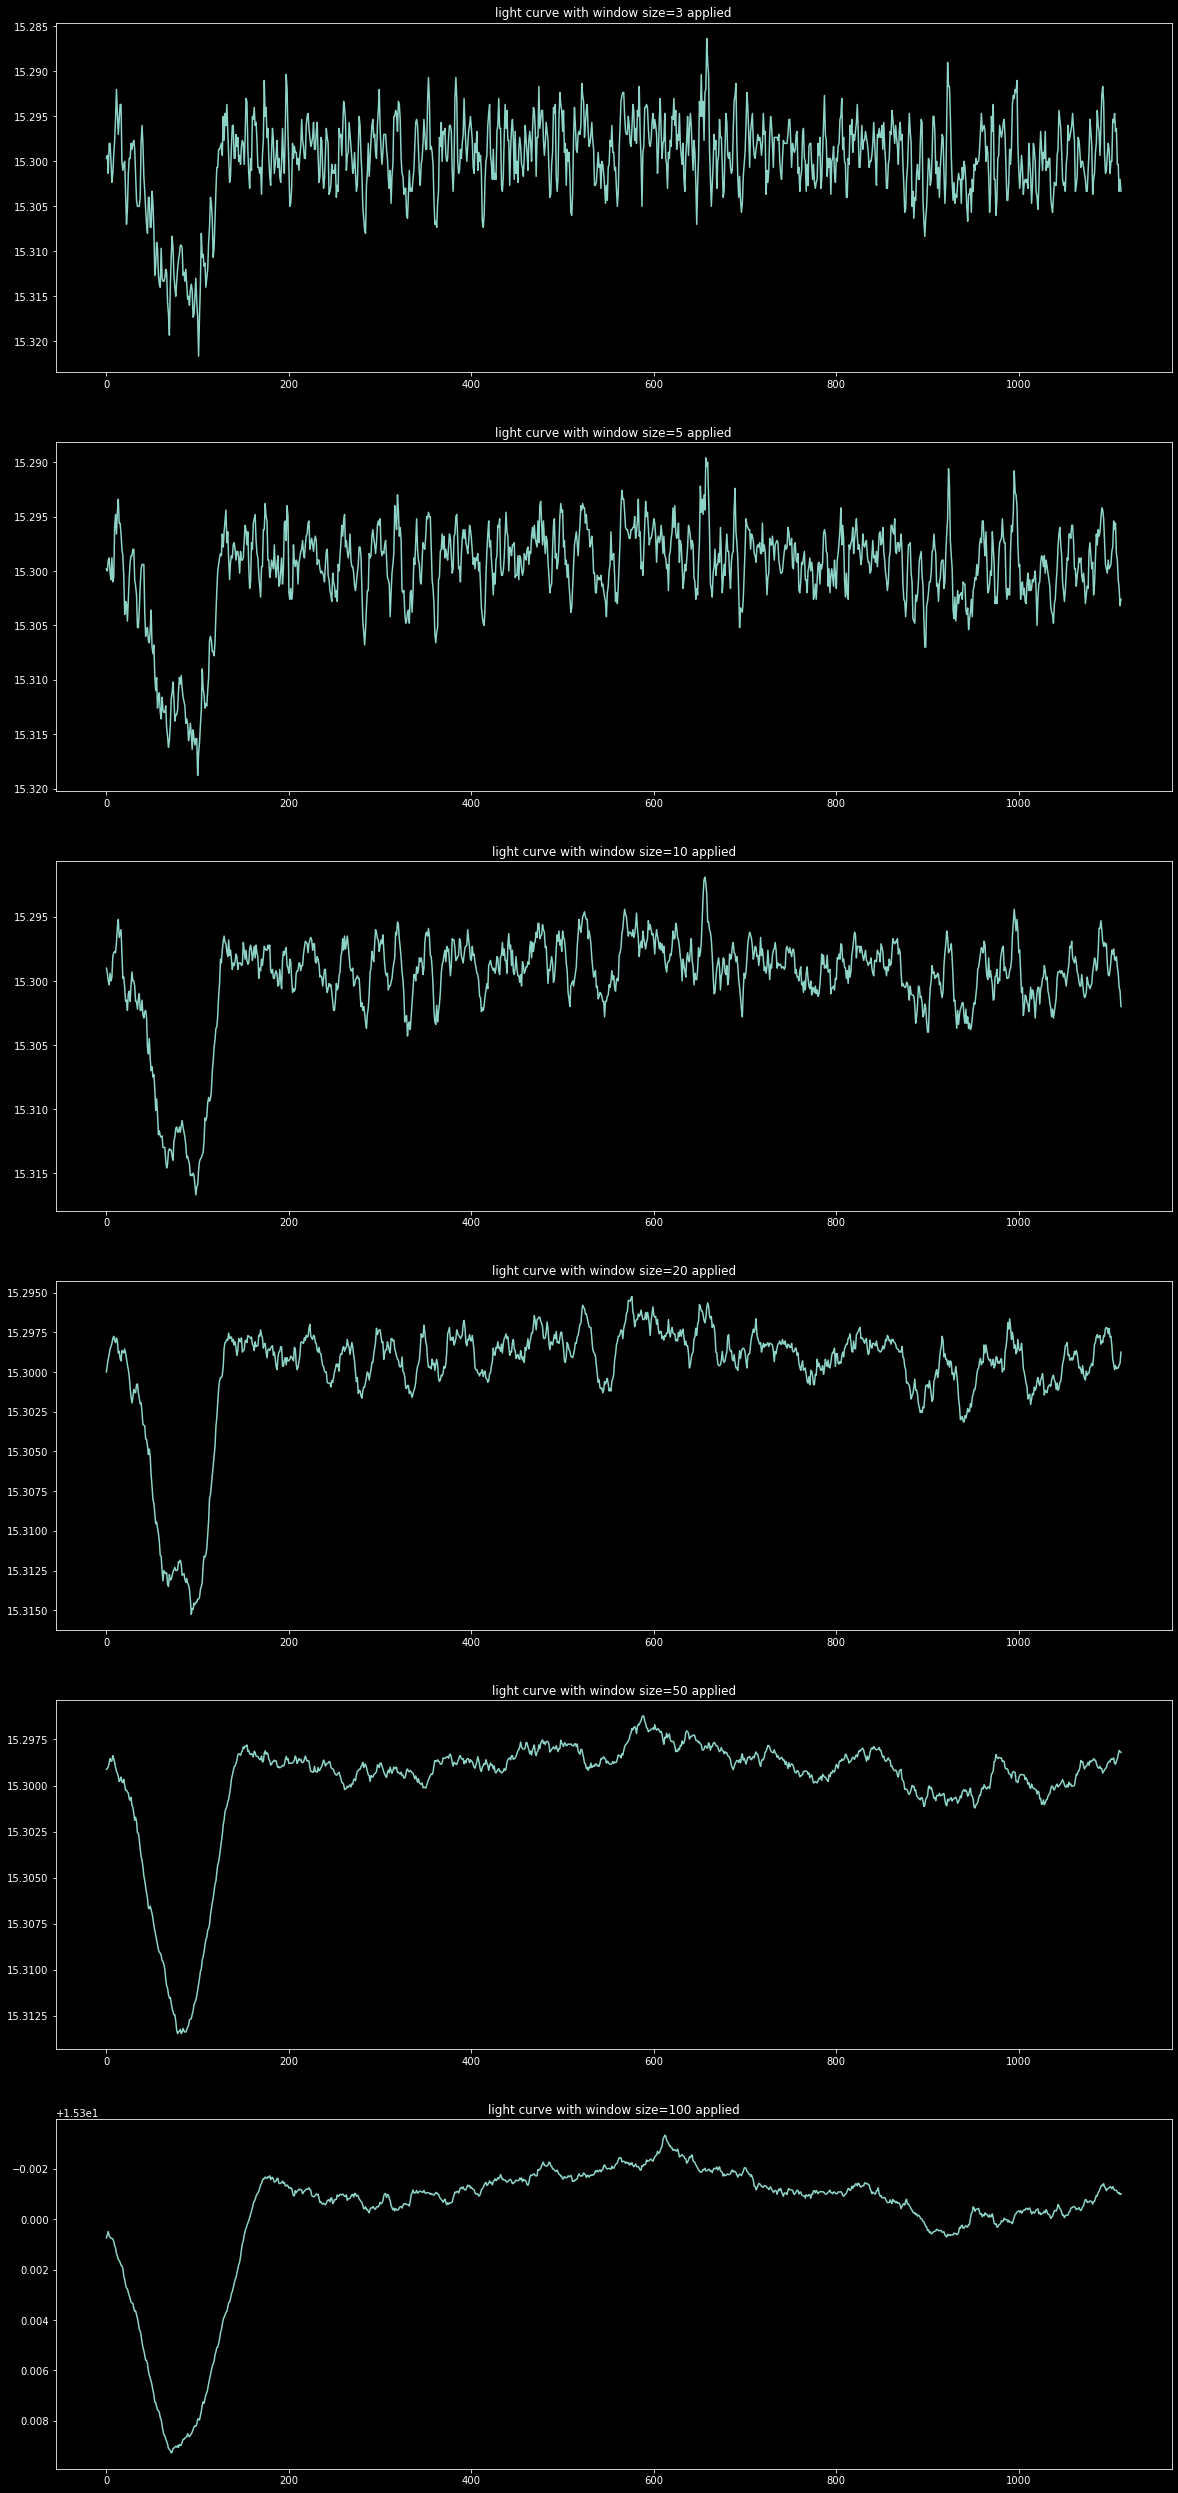

In [17]:
w_size = [3,5,10,20, 50, 100] #window sizes that we would like to try
fig, axs = plt.subplots(len(w_size), 1, figsize=(20,7.5*len(w_size)))

for i, row in enumerate(axs):
    i_band_avg = uniform_filter1d(i_band_mag_new, size = w_size[i])
    row.plot(i_band_avg)
    row.invert_yaxis()
    row.title.set_text(f'light curve with window size={w_size[i]} applied')

Window size of around 10 seems to work the best, smoothing the light curve while maintaining the most important structures. Let's use that from here.

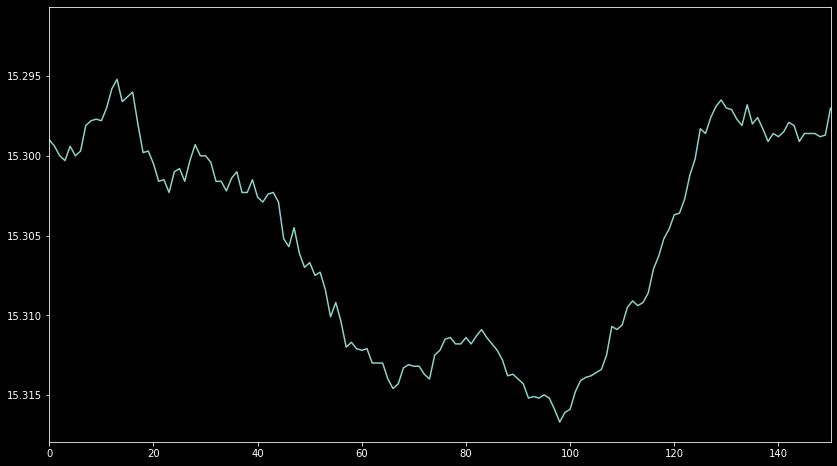

In [18]:
i_band_avg = uniform_filter1d(i_band_mag_new, size = 10)
plt.plot(i_band_avg)
plt.xlim([0,150])
plt.gca().invert_yaxis()

The magnitude dims over a period of around 20 data points
The magnitude remains at the minimum for around 40 data points 
However, assuming this curve should be symmetrical, and that the 20-60 range is inaccurate, we assume that the 100-120 range is the correct dimming curve, thus giving a transit period of around 40-100, or around 60 data points

In [19]:
print('These correlate to')
print(f'{(20/len(i_band_avg)): .3} of the whole star phase for the dimming of the star')
print(f'{(60/len(i_band_avg)): .3} of the whole star phase for the magnitude minimum')

These correlate to
 0.018 of the whole star phase for the dimming of the star
 0.0539 of the whole star phase for the magnitude minimum


In [20]:
stars_period = 1.2119*24*3600 #converted to seconds
semi_major_axis = (stars_period**2*((4*np.pi**2/(G*sun_mass))**-1))**(1/3)
newsemimajoraxis = ((stars_period**2*(1.49611e11)**3)/((365.25*86400)**2))**(1/3)
print (f'Semi-major axis of the planet orbit ={semi_major_axis: .3} m, or {(semi_major_axis/1.49611e11): .3} AU')
# print (f'Semi-major axis of the planet orbit ={newsemimajoraxis: .3} m, or {(newsemimajoraxis/1.49611e11): .3} AU')
#using Kepler's third to test my semi_major_axis line
transit_period = 0.0539 
dimming_period = 0.018#expressed in star's phase
star_radius = transit_period * 2*np.pi*semi_major_axis
planet_radius = dimming_period*2*np.pi*semi_major_axis #very crude approximation
print (f'The radius of the star is {star_radius: .3} m, or {star_radius/6.96e7 : .3} sun radius')
print (f'The radius of the planet is {planet_radius: .3} m, or {planet_radius/6.9911e7: .3} Jupiter radius')

Semi-major axis of the planet orbit = 3.33e+09 m, or  0.0222 AU
The radius of the star is  1.13e+09 m, or  16.2 sun radius
The radius of the planet is  3.76e+08 m, or  5.38 Jupiter radius


In [21]:
planet_period = stars_period
#star is sun-like, so the mass of the star is assumed the same as that of the sun's
planet_mass = (semi_major_axis**3/planet_period**2)*(4*np.pi**2/G)-sun_mass
print(semi_major_axis)
print(planet_period)
print(G)
print(sun_mass)

3328018581.068225
104708.16
6.673e-11
1.989e+30


## plan for the future: use kelpler's 3rd law to find the masses of the planets